## Helpdesk Issue Classification

### Step 1 - Problem Identification

The purpose of this project is to classify the nature of the issue reported by a customer to their technology partner's technical support helpdesk. 

Agents write up tickets for each issue reported by a customer and document the issue in several ways (X). One key feature is the freeform fields 'Problem Notes' (a brief description of the issue) and 'Action Notes' (an aggregation of agent documentation of steps taken and info gathered)

The target variable (y) is a series of 'Product Cat' fields, which we will consolidate into a single unique feature. Using supervised classification, I hope to use ML to find patterns between X and y such that I can predict what the 'Prod_Cat' ought to be. 

Being able to accurately predict the y variable would present substantial business value, as it is a constant challenge (training issue) getting agents to properly select the correct classification

In [148]:
# BASIC PACKAGES
import pandas as pd
import numpy as np
import missingno as msno

# VISUALIZATION PACKAGES
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt

# PRE-PROCESSING PACKAGES
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PowerTransformer

# MODELING PACKAGES
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [2]:
#READ IN LOCAL DATA AND EXPLORE IT
data_raw = pd.read_excel("wingstop.xlsx")

### Steps 2, 3 - Data Wrangling, EDA

In [5]:
print("Raw data shape:", data_raw.shape, '\n')
print(data_raw.dtypes)

Raw data shape: (9051, 31) 

Incident Identifier(NEOS)             object
Created Date                          object
Solution End Date Time TZ (Inc)       object
Duration Hours                        object
NEOS1                                 object
Team Name (Inc)                       object
Master Customer Name (Inc)            object
Master Customer Number (Inc)         float64
Customer Name                         object
Site Name (Inc)                       object
City (Inc)                            object
Severity Code (Inc)                  float64
Problem Note Text (Inc)               object
Action Notes                          object
Submitter Name (Inc)                  object
Operational Catogerization Tier 1     object
Operational Catogerization Tier 2     object
Operational Catogerization Tier 3     object
NEOS2                                 object
Product Cat Tier 1                    object
Product Cat Tier 2                    object
Product Cat Tier 3        

In [17]:
# DROP COLUMNS OUTSIDE THE SCOPE OF THIS CLASSIFICATION MODEL

drop_columns= ["Incident Identifier(NEOS)", "Solution End Date Time TZ (Inc)", "NEOS1", 
               "Created Date", "Master Customer Name (Inc)", "Master Customer Number (Inc)", 
               "Customer Name", "Site Name (Inc)", 'City (Inc)', "Submitter Name (Inc)", 
               "Operational Catogerization Tier 1", "Operational Catogerization Tier 2",
               "Operational Catogerization Tier 3", "Product Cat Tier 4", "Resolution Product Cat Tier 1", 
               "Resolution Product Cat Tier 2", "Resolution Product Cat Tier 3", 
               "Resolution Product Cat Tier 4", "NEOS2", "Closed by", 
               "Incident Status Description (Inc)"]
df1 = data_raw.drop(drop_columns, axis=1)
print(df1.columns)

Index(['Duration Hours', 'Team Name (Inc)', 'Severity Code (Inc)',
       'Problem Note Text (Inc)', 'Action Notes', 'Product Cat Tier 1',
       'Product Cat Tier 2', 'Product Cat Tier 3', 'FCR', 'RR'],
      dtype='object')


In [18]:
# SIMPLIFY COLUMN NAMES

cols_names= ["age_hours","team","sev","problem_notes","action_notes",
            "prod_cat1","prod_cat2","prod_cat3", "FCR","RR"]
df1.columns = cols_names
df1.dtypes

age_hours         object
team              object
sev               object
problem_notes     object
action_notes      object
prod_cat1         object
prod_cat2         object
prod_cat3         object
FCR              float64
RR               float64
dtype: object

***
CORRECT DTYPES
***

In [19]:
# FUNCTION TO EXAMINE THE NUMERIC SERIES PROVIDED AND REPLACE VALUES NOT MATCHING THE SPECIFIED
    # DTYPE WITH THE SERIES MEDIAN
    
def correct_dtype(df, series, dtype):
    df.loc[df[series].map(type) != dtype, series] \
        = df.loc[df[series].map(type) == dtype, series].median()

In [20]:
# CORRECT DTYPE FOR VALUES IN 'DURATION HOURS'

correct_dtype(df1, "age_hours", float)

In [21]:
# CORRECT DTYPES OF COLUMNS BASED ON DOMAIN KNOWLEDGE

df1['sev'] = df1['sev'].astype("object")
#data_raw['FCR'] = data_raw['FCR'].astype("object") // THIS IS ALREADY BINARY
#data_raw['RR'] = data_raw['RR'].astype("object") // THIS IS ALREADY BINARY

#data_raw['Product Cat Tier 1'] = data_raw['Product Cat Tier 1'].astype("string") // ALREADY OBJECT
#data_raw['Product Cat Tier 2'] = data_raw['Product Cat Tier 2'].astype("string") // ALREADY OBJECT
#data_raw['Product Cat Tier 3'] = data_raw['Product Cat Tier 3'].astype("string") // ALREADY OBJECT

***
HANDLE MISSING VALUES
***

<AxesSubplot:title={'center':'Missing Values'}, xlabel='Columns', ylabel='Percentage / Count'>

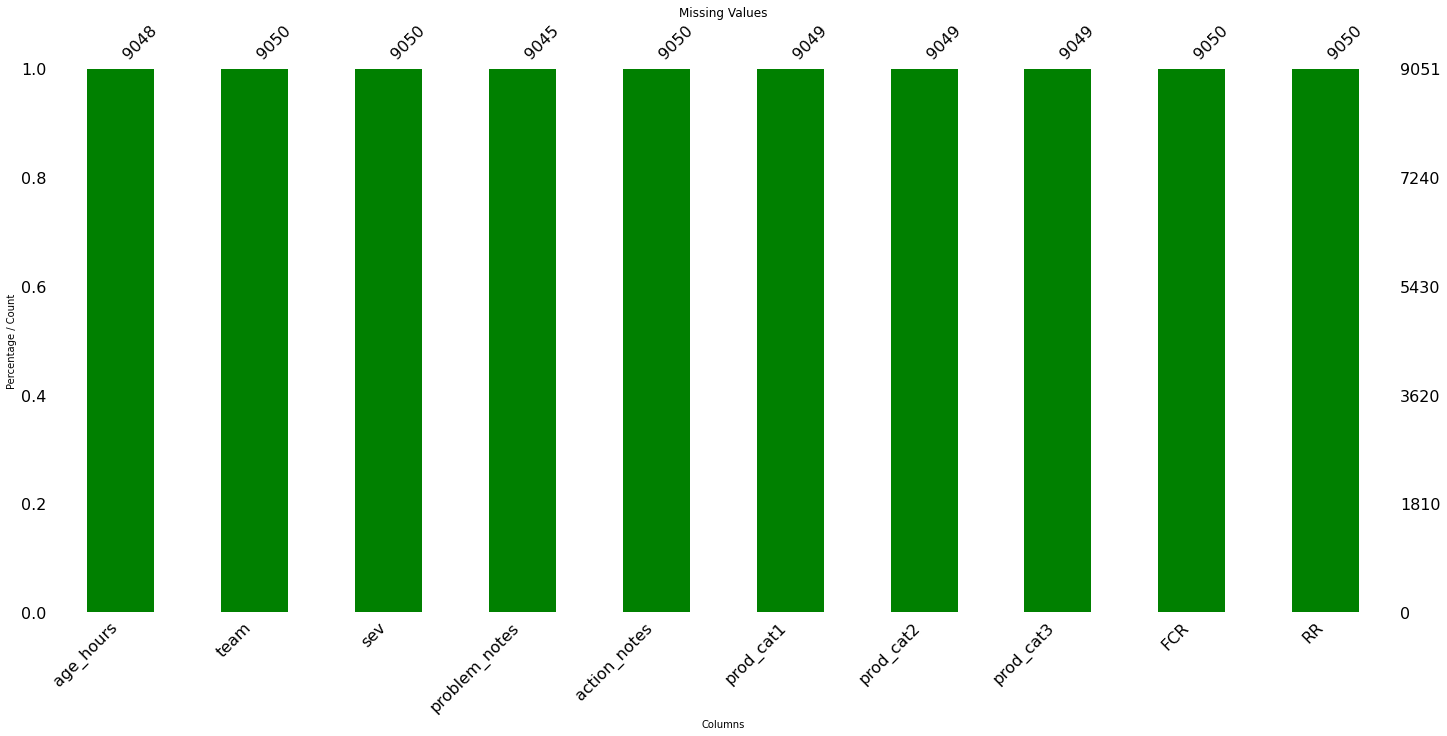

In [12]:
# CHECK FOR MISSING VALUES

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage / Count')
ax.set_title('Missing Values')
msno.bar(df1, color='green')

In [13]:
# IMPUTE MISSING VALUES IN AGE_HOURS USING MEDIAN() 

df1.age_hours.fillna(df1.age_hours.median(), inplace=True)
df1.age_hours.isna().sum()

0

DF2

In [34]:
# VALUES FROM REMAINING CATEGORICAL /TEXT COLUMNS CANNOT BE IMPUTED, DROPPING THESE ROWS

df2 = df1.dropna()
df2.reset_index(drop=True, inplace=True)

<AxesSubplot:title={'center':'Missing Values'}, xlabel='Columns', ylabel='Percentage / Count'>

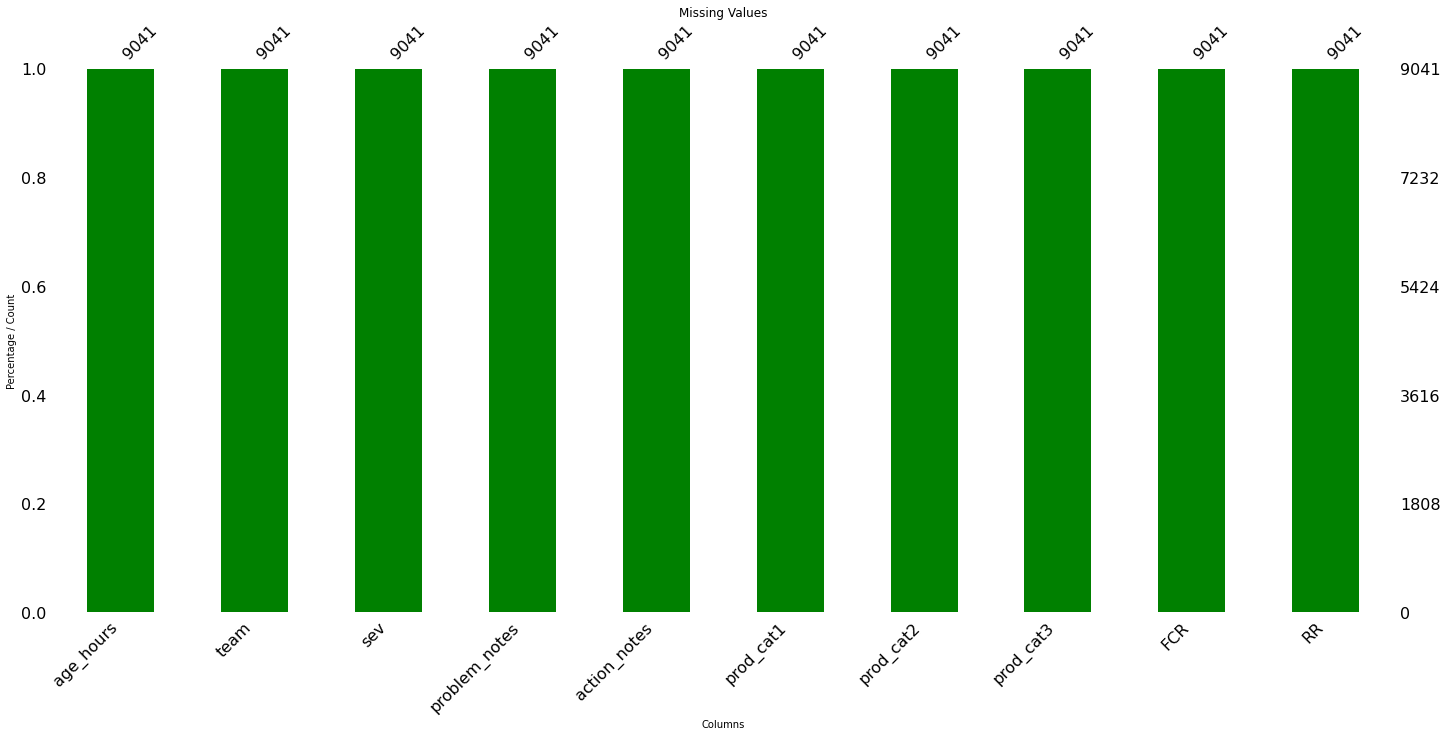

In [35]:
# MAKE SURE NO MISSING VALUES REMAIN

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage / Count')
ax.set_title('Missing Values')
msno.bar(df2, color='green')

***
HANDLING OUTLIERS
***

<AxesSubplot:title={'center':'Age Distribution'}, xlabel='Age (Hrs)', ylabel='Count in Bin'>

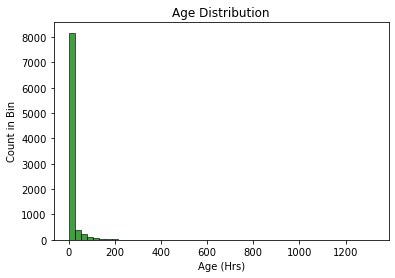

In [36]:
# CHECK FOR OUTLIERS WITHIN AGE_HOURS

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_xlabel('Age (Hrs)')
ax.set_ylabel('Count in Bin')
ax.set_title('Age Distribution')
sns.histplot(x='age_hours', data=df2, bins=50, color='green')

In [37]:
# CHECK PERCENTAGE OF CASES OUTSIDE THE TARGET THRESHOLD

print("Percentage of cases with Age > 300 hrs\n", 
      round(len(df2[df2['age_hours'] > 300]) / len(df2), 3), "%")

Percentage of cases with Age > 300 hrs
 0.002 %


In [38]:
# REPLACE OUTLIER VALUES WITH IMPUTED MEDIAN

df2.loc[df2.age_hours > 300, "age_hours"] = df2.loc[df2.age_hours < 300, "age_hours"].median()

C:\Users\DP185257\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:title={'center':'Age Distribution'}, xlabel='Age (Hrs)', ylabel='Count in Bin'>

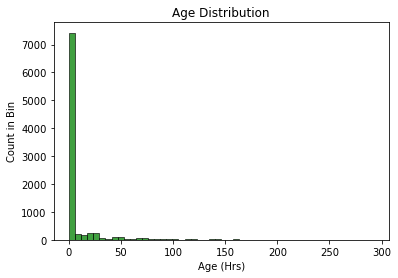

In [39]:
# CHECK FOR OUTLIERS WITHIN AGE_HOURS AGAIN

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_xlabel('Age (Hrs)')
ax.set_ylabel('Count in Bin')
ax.set_title('Age Distribution')
sns.histplot(x='age_hours', data=df2, bins=50, color='green')

***
FEATURE ENGINEERING
***

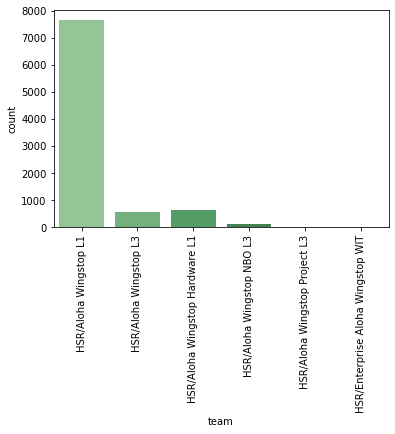

In [40]:
# CHECK DISTRIBUTION OF TEAM FEATURE

fig = plt.figure()
fig.patch.set_facecolor('white')
ax = sns.countplot(x='team', data=df2, palette='Greens_d')
plt.xticks(rotation=90)
plt.show()

In [41]:
# ITERATE THROUGH THE TEAM SERIES, EVALUATE STR OBJECTS THAT CONTAIN 'L1' AND POPULATE 'L1' FEATURE
# VALUE OF 1 INDICATES L1, VALUE OF 0 INDICATES L3

df2.loc[:,"L1"] = 0
for x in range(len(df2.team)):
    if df2.team[x].find(" L1") > 0:
        df2.loc[x, "L1"] = 1
    else:
        df2.loc[x, "L1"] = 0

C:\Users\DP185257\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\DP185257\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


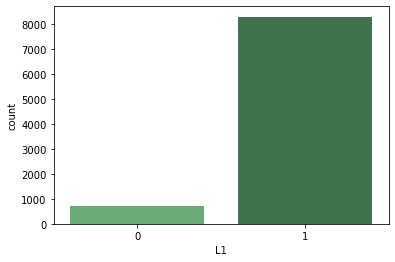

In [42]:
# SHOW CLASS BALANCE OF NEW L1 FEATURE

fig = plt.figure()
fig.patch.set_facecolor('white')
ax = sns.countplot(x='L1', data=df2, palette='Greens_d')
plt.show()

In [43]:
# MERGE TOGETHER THE TEXT COLUMNS FOR PROD_CAT, AS EVERY TICKET WILL HAVE SOME COMBINATION OF 
    # ALL 3 OF THESE TOGETHER. SO EACH COMBINATION REPRESENTS 1 CLASS IN THE CATEGORICAL FEATURE

df2.reset_index(drop=True, inplace=True
               )
df2.loc[:,"prod_cat"] = df2.loc[:,"prod_cat1"]
for i in range(len(df2.prod_cat)):
    df2.loc[i, "prod_cat"] = df2.loc[i, "prod_cat1"] + "," + df2.loc[i, "prod_cat2"] + "," + df2.loc[i, "prod_cat3"]

# REMOVE LABELS NOT OCCURRING AT LEAST 10 TIMES

ind_list= list(df2.prod_cat.value_counts()[df2.prod_cat.value_counts() < 25].index)
df2= df2.loc[~df2['prod_cat'].isin(ind_list)]

# DROP ORIGINAL PROD_CAT * COLUMNS

df2.drop(["prod_cat1", "prod_cat2", "prod_cat3"], axis=1, inplace=True)
df2.prod_cat.value_counts()

C:\Users\DP185257\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\DP185257\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


z_Third Party,Third Party SW Not Working,Third Party SW Not Working    633
z_NCR Back Office,Sales,Sales                                          497
z_Aloha POS,Front Of House,Missing employee                            450
z_NCR Back Office,Labor,Labor                                          415
z_Aloha POS,Site/Store Down,Determining File Server                    396
                                                                      ... 
z_Aloha POS,Front Of House,Can't assign drawer                          27
z_Terminal,Power,Randomly Shuts Off                                     26
z_Terminal,Power,HW Failure                                             26
z_Terminal,Time / Date,Time Incorrect                                   25
z_Electronic Draft Capture,Back Of House,Refund                         25
Name: prod_cat, Length: 64, dtype: int64

In [45]:
# CORRECT DATA TYPE AGAIN FOR VARIOUS NUMERIC COLUMNS THAT SHOULD BE CATEGORICAL

df2.FCR = [str(int(x)) for x in df2["FCR"]]
df2.RR = [str(int(x)) for x in df2["RR"]]
df2.L1 = [str(x) for x in df2["L1"]]
df2.sev = [str(int(x)) for x in df2["sev"]]
df2.dtypes

age_hours        object
team             object
sev              object
problem_notes    object
action_notes     object
FCR              object
RR               object
L1               object
prod_cat         object
dtype: object

In [46]:
df2.head()

,age_hours,team,sev,problem_notes,action_notes,FCR,RR,L1,prod_cat
0,0.046389,HSR/Aloha Wingstop L1,1,1. Site Name/Site Number (GEMS): 38 \n2. Po...,2022-03-31 23:11 - dv250157\nGeneral Informati...,1,0,1,"z_PinPad / CC Machine,Display,Incorrect Screen"
1,0.065278,HSR/Aloha Wingstop L1,2,Employee export,2022-03-31 23:23 - vb250277\nWorking Log: Fiel...,1,0,1,"z_NCR Back Office,Database,Database"
2,0.821667,HSR/Aloha Wingstop L1,0,WNG - Store offline - Internet issue,2022-04-01 00:09 - dv250157\nWorking Log: Fiel...,1,0,1,"z_Third Party,Internet Service Provider,Intern..."
3,12.002778,HSR/Aloha Wingstop L1,0,WNG - All terms down,2022-04-01 00:18 - dv250157\nWorking Log: Fiel...,0,0,1,"z_Aloha POS,Site/Store Down,Determining File S..."
4,14.766944,HSR/Aloha Wingstop L1,2,FOH-Printer rerouting,2022-04-01 01:00 - vv250206\nWorking Log: Fiel...,0,0,1,"z_Printer,Won't Print,HW Failure"


In [47]:
# ENGINEER NEW FEATURES FOR LEN() OF USER ENTRY FIELDS

df2["prob_notes_len"] = [len(x) for x in df2.problem_notes]
df2["act_notes_len"] = [len(x) for x in df2.action_notes]

<AxesSubplot:title={'center':'Len() of Problem Notes'}, xlabel='Number of characters', ylabel='Count'>

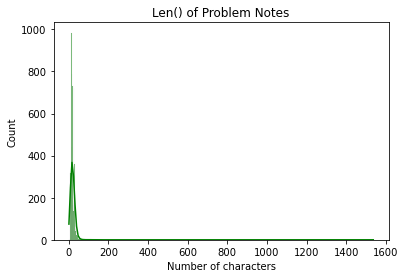

In [48]:
# COMPARE LEN OF PROB NOTES AND ACT NOTES, BOTH WILL SURELY NEED TO BE REGULARIZED FOR ML

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_title('Len() of Problem Notes')
ax.set_xlabel('Number of characters')
sns.histplot(data=df2, x="prob_notes_len", color="green", kde=True)

<AxesSubplot:title={'center':'Len() of Action Notes'}, xlabel='Number of characters', ylabel='Count'>

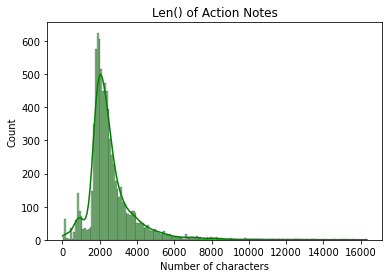

In [49]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_xlabel('Number of characters')
ax.set_title('Len() of Action Notes')
sns.histplot(data=df2, x="act_notes_len", color="green", kde=True)

### Step 4 - Pre-processing

***
TEXT PRE-PROCESSING
***

In [51]:
### FUNCTION TO TAKE A SERIES OF TEXT AND CLEAN IT, REMOVING SPECIAL CHARACTERS, 
    ### REPLACING NEW LINES WITH " ", AND LOWER() ON EVERYTHING

def clean_text(series): 
    new_series = series.str.replace('[^a-zA-Z \n]', '')
    new_series = new_series.str.replace('\n', ' ')
    new_series = new_series.str.lower()
    return new_series

In [52]:
df2.reset_index(drop=True, inplace=True)

DF3

In [53]:
# COMBINE PROBLEM_NOTES AND ACTION_NOTES SINCE THEY ARE COMPARABLE FIELDS THAT CAN BE VECTORIZED TOGETHER

prob_series= clean_text(df2['problem_notes'])
act_series= clean_text(df2['action_notes'])

df3= df2.drop(['action_notes', 'problem_notes'], axis=1)
df3.loc[:,"combined_notes"] = [(prob_series[x] + act_series[x]) for x in range(len(df2))]
print(df3.combined_notes.head())

C:\Users\DP185257\AppData\Local\Temp/ipykernel_15876/1607333787.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  new_series = series.str.replace('[^a-zA-Z \n]', '')


0     site namesite number gems       point of cont...
1    employee export    vb working log field values...
2    wng  store offline  internet issue   dv workin...
3    wng  all terms down   dv working log field val...
4    fohprinter rerouting    vv working log field v...
Name: combined_notes, dtype: object


***
##### NOTE: CLEANING NUMBERS FROM NOTES REMOVES REFERENCES LIKE T1 ETC
*May reconsider this for future scope*
***

In [54]:
df3.columns

Index(['age_hours', 'team', 'sev', 'FCR', 'RR', 'L1', 'prod_cat',
       'prob_notes_len', 'act_notes_len', 'combined_notes'],
      dtype='object')

In [55]:
# FUNCTION TO APPLY GET_DUMMIES TO A SPECIFIED CATEGORICAL FEATURE, THEN DROP ORIGINAL COLUMN

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

DF5

In [56]:
df5= encode_and_bind(df3, 'team')
df5.columns

Index(['age_hours', 'sev', 'FCR', 'RR', 'L1', 'prod_cat', 'prob_notes_len',
       'act_notes_len', 'combined_notes', 'HSR/Aloha Wingstop Hardware L1',
       'HSR/Aloha Wingstop L1', 'HSR/Aloha Wingstop L3',
       'HSR/Aloha Wingstop NBO L3', 'HSR/Aloha Wingstop Project L3',
       'HSR/Enterprise Aloha Wingstop WIT'],
      dtype='object')

In [160]:
df5.to_excel('data_wrangled.xlsx')

In [57]:
# Instantiate TfidfVectorizer

tv = TfidfVectorizer(stop_words='english',
                    min_df=10, ngram_range=(1,3))

# Fit the vectorizer and transform the data
tv_transformed = tv.fit_transform(df3['combined_notes'])

# Create a DataFrame with these features
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                     columns=tv.get_feature_names()).add_prefix('TFIDF_')

In [58]:
tv_df.shape

(8222, 17223)

DF6

In [60]:
df6 = pd.concat([df5, tv_df], axis=1)
df6.drop('combined_notes', axis=1, inplace=True)
df6.head()

,age_hours,sev,FCR,RR,L1,prod_cat,prob_notes_len,act_notes_len,HSR/Aloha Wingstop Hardware L1,HSR/Aloha Wingstop L1,...,TFIDF_zn reason,TFIDF_zn reason action,TFIDF_zn reason field,TFIDF_zn status,TFIDF_zn status marked,TFIDF_zn working,TFIDF_zn working log,TFIDF_zn zn,TFIDF_zn zn working,TFIDF_zn zn zn
0,0.046389,1,1,0,1,"z_PinPad / CC Machine,Display,Incorrect Screen",1048,3173,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.065278,2,1,0,1,"z_NCR Back Office,Database,Database",16,2405,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.821667,0,1,0,1,"z_Third Party,Internet Service Provider,Intern...",36,2279,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.002778,0,0,0,1,"z_Aloha POS,Site/Store Down,Determining File S...",20,4715,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.766944,2,0,0,1,"z_Printer,Won't Print,HW Failure",22,3009,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# SPLIT DEPENDENT AND INDEPENDENT VARIABLES INTO X, Y

X = df6.drop(['prod_cat'], axis=1)
y = df6['prod_cat']
print(X.shape)
print(y.shape)

(8222, 17236)
(8222,)


In [63]:
#Split data into Train and Test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6166, 17236) (2056, 17236)
(6166,) (2056,)


In [ ]:
# Perform scaling on irregular distribution data

In [64]:
pt = PowerTransformer()
pt.fit(X_train)

PowerTransformer()

In [132]:
X_train_scaled= pt.transform(X_train)
X_test_scaled= pt.transform(X_test)

### Step 5 - Modeling

***
RANDOM FOREST
***

In [133]:
rf_model= RandomForestClassifier(random_state=123)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf= rf_model.predict(X_test_scaled)

In [134]:
# PERFORMANCE ISN'T BAD, BUT FAR FROM GOOD

print(classification_report(y_test,y_pred_rf))

                                                                          precision    recall  f1-score   support

                           z_Aloha Manager / CFC,Employees,Configuration       0.57      0.60      0.59        20
                              z_Aloha POS,CTLSVR/Control Service,Stopped       0.94      0.94      0.94        31
               z_Aloha POS,End Of Day,Waiting for End Of Day to Complete       1.00      0.83      0.91        18
                          z_Aloha POS,Front Of House,Can't assign drawer       0.57      0.57      0.57         7
                               z_Aloha POS,Front Of House,Checkout issue       0.81      0.81      0.81        16
                    z_Aloha POS,Front Of House,Clock In/Clock Out issues       0.73      0.40      0.52        20
                           z_Aloha POS,Front Of House,Enroll fingerprint       0.58      0.64      0.61        11
                             z_Aloha POS,Front Of House,Missing employee       0.90    

C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***
GRADIENT BOOSTING
***

In [69]:
'''
grad_model= GradientBoostingClassifier(random_state=123)
grad_model.fit(X_train, y_train)
y_pred_grad= grad_model.predict(X_test)

print(classification_report(y_test,y_pred_grad))
'''
# 2HR+ TRAINING TIME, ABANDONED

KeyboardInterrupt: 

***
LOGISTIC REGRESSION
***

In [77]:
log_model= LogisticRegression(random_state=123, solver='liblinear', C=0.1)
log_model.fit(X_train, y_train)
y_pred_log= log_model.predict(X_test)

# DEFAULT HYPER PARAMS FAILED TO CONVERGE, EVEN AT MAX_ITER=300

C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [76]:
# WITH LIBLINEAR AND C=0.1, PERFORMANCE IS VERY POOR

print(classification_report(y_test,y_pred_log))

                                                                          precision    recall  f1-score   support

                           z_Aloha Manager / CFC,Employees,Configuration       0.00      0.00      0.00        20
                              z_Aloha POS,CTLSVR/Control Service,Stopped       0.96      0.77      0.86        31
               z_Aloha POS,End Of Day,Waiting for End Of Day to Complete       0.93      0.78      0.85        18
                          z_Aloha POS,Front Of House,Can't assign drawer       0.00      0.00      0.00         7
                               z_Aloha POS,Front Of House,Checkout issue       0.00      0.00      0.00        16
                    z_Aloha POS,Front Of House,Clock In/Clock Out issues       0.00      0.00      0.00        20
                           z_Aloha POS,Front Of House,Enroll fingerprint       0.00      0.00      0.00        11
                             z_Aloha POS,Front Of House,Missing employee       0.40    

C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***
SVM.LINEARSVC
***

In [79]:
svm_model= svm.LinearSVC(random_state=123)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# FAILED TO CONVERGE ALSO

C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Splitting Vocabulary and non-Vocabulary features to test models again

### VOCABULARY FEATURES ONLY

In [106]:
X_tfidf= X.drop(X.columns[0:13], axis=1)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = \
                                        train_test_split(X_tfidf, y, test_size=0.25, random_state=123)
print(X_train_tfidf.shape, X_test_tfidf.shape)
print(y_train_tfidf.shape, t_test_tfidf.shape)

(6166, 17223) (2056, 17223)
(6166,) (2056,)


***
RANDOM FOREST- TFIDF
***

In [108]:
rf_model_tfidf= RandomForestClassifier(random_state=123)
rf_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_rf_tfidf= rf_model_tfidf.predict(X_test_tfidf)

In [109]:
# THIS TFIDF-ONLY VERSION OF RANDOM FOREST SLIGHTLY OUTPERFORMS THE FIRST VERSION WITH ALL FEATURES

print(classification_report(y_test_tfidf,y_pred_rf_tfidf))

                                                                          precision    recall  f1-score   support

                           z_Aloha Manager / CFC,Employees,Configuration       0.60      0.60      0.60        20
                              z_Aloha POS,CTLSVR/Control Service,Stopped       0.91      0.94      0.92        31
               z_Aloha POS,End Of Day,Waiting for End Of Day to Complete       1.00      0.83      0.91        18
                          z_Aloha POS,Front Of House,Can't assign drawer       0.57      0.57      0.57         7
                               z_Aloha POS,Front Of House,Checkout issue       0.76      0.81      0.79        16
                    z_Aloha POS,Front Of House,Clock In/Clock Out issues       0.83      0.50      0.62        20
                           z_Aloha POS,Front Of House,Enroll fingerprint       0.75      0.55      0.63        11
                             z_Aloha POS,Front Of House,Missing employee       0.89    

***
GRADIENT BOOSTER- TFIDF
***

In [110]:
grad_model_tfidf= GradientBoostingClassifier(random_state=123)
grad_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_grad_tfidf= grad_model_tfidf.predict(X_test_tfidf)

# FAILED TO TRAIN IN 10+ MIN, ABANDONED, MAY RETURN TO THIS LATER

KeyboardInterrupt: 

***
LOGISTIC REGRESSION- TFIDF
***

In [112]:
# CREATE AND FIT LOGISTIC REGRESSOR

LogReg_tfidf= LogisticRegression(random_state=123)
LogReg_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_log_tfidf= LogReg_tfidf.predict(X_test_tfidf)

In [113]:
# PERFORMANCE IS VERY SIMILAR TO RANDOM FOREST TFIDF, NOT SIGNIFICANTLY BETTER/WORSE

print(classification_report(y_test_tfidf,y_pred_log_tfidf))

                                                                          precision    recall  f1-score   support

                           z_Aloha Manager / CFC,Employees,Configuration       0.72      0.65      0.68        20
                              z_Aloha POS,CTLSVR/Control Service,Stopped       0.90      0.87      0.89        31
               z_Aloha POS,End Of Day,Waiting for End Of Day to Complete       1.00      0.83      0.91        18
                          z_Aloha POS,Front Of House,Can't assign drawer       0.75      0.43      0.55         7
                               z_Aloha POS,Front Of House,Checkout issue       0.68      0.81      0.74        16
                    z_Aloha POS,Front Of House,Clock In/Clock Out issues       0.80      0.60      0.69        20
                           z_Aloha POS,Front Of House,Enroll fingerprint       0.89      0.73      0.80        11
                             z_Aloha POS,Front Of House,Missing employee       0.87    

C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***
SVM.LINEARSVC- TFIDF
***

In [115]:
# CREATE AND FIT LINEARSVC MODEL

svm_model_tfidf= svm.LinearSVC(random_state=123)
svm_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_svm_tfidf= svm_model_tfidf.predict(X_test_tfidf)

In [116]:
# SVM PERFORMANCE IS SEVERAL POINTS HIGHER THAN ANY PREVIOUS MODELS

print(classification_report(y_test_tfidf,y_pred_svm_tfidf))

                                                                          precision    recall  f1-score   support

                           z_Aloha Manager / CFC,Employees,Configuration       0.67      0.70      0.68        20
                              z_Aloha POS,CTLSVR/Control Service,Stopped       0.88      0.97      0.92        31
               z_Aloha POS,End Of Day,Waiting for End Of Day to Complete       1.00      0.94      0.97        18
                          z_Aloha POS,Front Of House,Can't assign drawer       0.60      0.86      0.71         7
                               z_Aloha POS,Front Of House,Checkout issue       0.54      0.81      0.65        16
                    z_Aloha POS,Front Of House,Clock In/Clock Out issues       0.72      0.65      0.68        20
                           z_Aloha POS,Front Of House,Enroll fingerprint       0.64      0.64      0.64        11
                             z_Aloha POS,Front Of House,Missing employee       0.90    

In [154]:
'''calib= CalibratedClassifierCV(svm_model_tfidf)
calib.fit(X_train_tfidf, y_train_tfidf)
y_proba= calib.predict_proba(X_test_tfidf)'''
# ATTEMPTED TO VISUALIZE CLASSIFICATION REPORT RESULTS, BUT THERE ARE TOO MANY FEATURES
                # IT CRAMS THE FIGURE TOO MUCH FOR READABILITY

array([[7.41381125e-03, 1.20839084e-03, 1.21395516e-03, ...,
        1.07679807e-04, 4.00166776e-03, 1.13770205e-02],
       [2.15273986e-03, 1.49201052e-03, 8.69158669e-04, ...,
        2.04517355e-03, 3.33509235e-03, 5.62746425e-03],
       [1.39093227e-03, 3.66953327e-03, 8.32309983e-04, ...,
        2.12795976e-03, 1.14649036e-02, 4.79317914e-05],
       ...,
       [7.52476895e-04, 1.51976775e-03, 8.66126538e-04, ...,
        1.29813666e-04, 2.22322313e-03, 4.89338266e-03],
       [5.47548601e-03, 3.71892758e-03, 1.81763790e-03, ...,
        3.09549950e-03, 2.93547399e-03, 1.16036081e-02],
       [1.21403666e-02, 1.03947633e-03, 1.00861899e-03, ...,
        1.16849618e-03, 4.75450598e-03, 6.89946904e-01]])

### NON-VOCABULARY FEATURES ONLY

In [119]:
X_non= X.iloc[:,0:13]

X_train_non, X_test_non, y_train_non, y_test_non = \
                                        train_test_split(X_non, y, test_size=0.25, random_state=123)
print(X_train_non.shape, X_test_non.shape)
print(y_train_non.shape, y_test_non.shape)

(6166, 13) (2056, 13)
(6166,) (2056,)


In [157]:
# POWER TRANSFORM THE FEATURES AGAIN ON THE NON-TFIDF X

pt = PowerTransformer()
pt.fit(X_train_non)

PowerTransformer()

***
RANDOM FOREST- NON-TFIDF
***

In [120]:
rf_model_non= RandomForestClassifier(random_state=123)
rf_model_non.fit(X_train_non, y_train_non)
y_pred_rf_non= rf_model_non.predict(X_test_non)

In [121]:
# THIS NON-TFIDF VERSION OF RANDOM FOREST IS FAR WORSE THAN PREVIOUS VERSIONS

print(classification_report(y_test_non,y_pred_rf_non))

                                                                          precision    recall  f1-score   support

                           z_Aloha Manager / CFC,Employees,Configuration       0.06      0.05      0.06        20
                              z_Aloha POS,CTLSVR/Control Service,Stopped       0.57      0.55      0.56        31
               z_Aloha POS,End Of Day,Waiting for End Of Day to Complete       0.53      0.56      0.54        18
                          z_Aloha POS,Front Of House,Can't assign drawer       0.00      0.00      0.00         7
                               z_Aloha POS,Front Of House,Checkout issue       0.20      0.19      0.19        16
                    z_Aloha POS,Front Of House,Clock In/Clock Out issues       0.00      0.00      0.00        20
                           z_Aloha POS,Front Of House,Enroll fingerprint       0.00      0.00      0.00        11
                             z_Aloha POS,Front Of House,Missing employee       0.54    

***
GRADIENT BOOSTER- NON-TFIDF
***

In [122]:
grad_model_non= GradientBoostingClassifier(random_state=123)
grad_model_non.fit(X_train_non, y_train_non)
y_pred_grad_non= grad_model_non.predict(X_test_non)

In [125]:
# MILDLY OUTPERFORMED THE POOR PERFORMANCE OF NON-TFIDF RF

print(classification_report(y_test_non, y_pred_grad_non))

                                                                          precision    recall  f1-score   support

                           z_Aloha Manager / CFC,Employees,Configuration       0.12      0.05      0.07        20
                              z_Aloha POS,CTLSVR/Control Service,Stopped       0.56      0.45      0.50        31
               z_Aloha POS,End Of Day,Waiting for End Of Day to Complete       0.67      0.56      0.61        18
                          z_Aloha POS,Front Of House,Can't assign drawer       0.00      0.00      0.00         7
                               z_Aloha POS,Front Of House,Checkout issue       0.00      0.00      0.00        16
                    z_Aloha POS,Front Of House,Clock In/Clock Out issues       0.00      0.00      0.00        20
                           z_Aloha POS,Front Of House,Enroll fingerprint       0.00      0.00      0.00        11
                             z_Aloha POS,Front Of House,Missing employee       0.59    

***
SVM.LINEARSVC- NON-TFIDF
***

In [128]:
# CREATE AND FIT LINEARSVC MODEL

svm_model_non= svm.LinearSVC(random_state=123)
svm_model_non.fit(X_train_non, y_train_non)
y_pred_svm_non= svm_model_non.predict(X_test_non)

C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [129]:
# SVM PERFORMANCE FOR NON-TFIDF IS THE WORST OF ANY MODEL YET 

print(classification_report(y_test_non,y_pred_svm_non))

                                                                          precision    recall  f1-score   support

                           z_Aloha Manager / CFC,Employees,Configuration       0.00      0.00      0.00        20
                              z_Aloha POS,CTLSVR/Control Service,Stopped       0.00      0.00      0.00        31
               z_Aloha POS,End Of Day,Waiting for End Of Day to Complete       0.00      0.00      0.00        18
                          z_Aloha POS,Front Of House,Can't assign drawer       0.00      0.00      0.00         7
                               z_Aloha POS,Front Of House,Checkout issue       0.00      0.00      0.00        16
                    z_Aloha POS,Front Of House,Clock In/Clock Out issues       0.00      0.00      0.00        20
                           z_Aloha POS,Front Of House,Enroll fingerprint       0.00      0.00      0.00        11
                             z_Aloha POS,Front Of House,Missing employee       0.19    

C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clearly, we are seeing the most patterns available from just the TFIDF input. 

### OPTIMIZE BEST MODEL- TFIDF LINEARSVC

In [140]:
param_grid= {'C':[0.1, 1, 10], "loss":['hinge','squared_hinge']}

hrs= HalvingRandomSearchCV(svm_model_tfidf, param_grid)
hrs.fit(X_train_tfidf, y_train_tfidf)

C:\Users\DP185257\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=9. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(estimator=LinearSVC(random_state=123),
                      param_distributions={'C': [0.1, 1, 10],
                                           'loss': ['hinge', 'squared_hinge']},
                      refit=<function _refit_callable at 0x00000239A68C0AF0>)

In [141]:
# DETERMINE BEST PARAMETERS FOR LINEARSVC

hrs.best_params_

{'loss': 'squared_hinge', 'C': 1}

These parameters are the same as the default params of the SVC model, so no further tuning is necessary

### Conclusions

In the goal of taking helpdesk ticket data and classifying it into the available labels for categorization, this project was not as successful as I had hoped. Success was limited by the lack of text data cleanliness; additionally, the huge number of target prediction classes meant that even this large ~10K-row dataset was not able to allow for sufficient model training on some unrepresented classes. 

The freeform text fields (Problem Notes, Action Notes) appear to hold the most value in pattern identification, and if further pre-processing was done to clean up the content of them, their value could be recognized even further. Even still, the scores were not too bad for about half of the classes, and it is likely that performance can be improved even further via implementation of the steps listed in Future Scope. 

##### Business Insight
This tool could be used in its current form to make specific classifications on huge amounts of helpdesk ticket data, which could serve to lower training costs and improve data accuracy. Improved data accuracy could be used by Product teams to better understand bugs and gaps in their software and make improvements on behalf of the users

***
FUTURE SCOPE
***

1. Larger dataset to give more rows for each class in the target variable
2. Try more n-grams, such as 3 or even 4
3. Reduce target classes to fewer selections to improve scores for remaining classes
4. Neural net model
5. Better text pre-processing of Action Notes, which are cluttered with irrelevant words, e.g. email headers, agent IDs, date/times, etc
6. 